<a href="https://colab.research.google.com/github/schmeks/911-311_Complaints/blob/master/311_Complaint_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reviewing 311 Complaint Data from NYC's Open Data Portal**
Becca Mason

This collab notebook takes NYPD Historic Complaint Data and Explores the content with preliminary analyses. Presents findings on the age breakdown of victims and suspects, location of complaint, and gender of victim.

# Import Data via one of two methods: API or csv 

## Complaint data from NYC Open Data via Socrata API, filtered down to Violations only

In [2]:
#installing Sodapy library and other necessary packages

# https://data.cityofnewyork.us/resource/qgea-i56i.json
!pip install sodapy

import pandas as pd
from sodapy import Socrata
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", None)

In [0]:
# First results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("5uac-w243")

# df = pd.read_csv('https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD')
# df.head()
# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

## Alternatively, import csv to avoid throttling limits and/or slow upload speeds.

Note that this data only consists of data from 2019

In [5]:
# Import csv, ignoring errors

results = pd.read_csv('https://raw.githubusercontent.com/schmeks/911-311_Complaints/master/NYPDViolationData.csv', error_bad_lines=False)
results_df = results.copy()
print('data loaded successfully')

data loaded successfully


In [6]:
results_df.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,781940970,115,QUEENS,01/05/2019,08:45:00,01/05/2019,08:47:00,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,578,VIOLATION,INSIDE,HARRASSMENT 2,NaN,PATROL BORO QUEENS NORTH,638,"HARASSMENT,SUBD 3,4,5",RESTAURANT/DINER,01/05/2019,NaN,UNKNOWN,BLACK,F,NaN,25-44,WHITE HISPANIC,M,1016395,214622,40.755714,-73.883975,"(40.755714116000036, -73.88397502899994)"
1,835070274,70,BROOKLYN,01/03/2019,18:30:00,01/03/2019,18:45:00,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,578,VIOLATION,INSIDE,HARRASSMENT 2,NaN,PATROL BORO BKLYN SOUTH,638,"HARASSMENT,SUBD 3,4,5",CHAIN STORE,01/03/2019,NaN,UNKNOWN,BLACK,F,NaN,25-44,BLACK,F,995885,174602,40.645919,-73.958074,"(40.64591936100004, -73.95807437399996)"
2,868311027,10,MANHATTAN,01/02/2019,17:05:00,01/02/2019,17:08:00,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,578,VIOLATION,INSIDE,HARRASSMENT 2,NaN,PATROL BORO MAN SOUTH,637,"HARASSMENT,SUBD 1,CIVILIAN",FAST FOOD,01/02/2019,NaN,UNKNOWN,WHITE,M,NaN,25-44,BLACK,M,984991,211390,40.746901,-73.997327,"(40.74690148800004, -73.99732718499997)"
3,249096292,19,MANHATTAN,01/06/2019,08:45:00,01/06/2019,08:58:00,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,578,VIOLATION,FRONT OF,HARRASSMENT 2,NaN,PATROL BORO MAN NORTH,637,"HARASSMENT,SUBD 1,CIVILIAN",STREET,01/06/2019,NaN,25-44,ASIAN / PACIFIC ISLANDER,M,NaN,25-44,ASIAN / PACIFIC ISLANDER,F,998583,222146,40.776412,-73.948251,"(40.77641236200003, -73.94825084599995)"
4,691512468,71,BROOKLYN,01/05/2019,18:10:00,01/05/2019,18:15:00,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,578,VIOLATION,INSIDE,HARRASSMENT 2,NaN,PATROL BORO BKLYN SOUTH,638,"HARASSMENT,SUBD 3,4,5",RESIDENCE - APT. HOUSE,01/05/2019,NaN,18-24,BLACK,M,NaN,18-24,BLACK,F,997631,178916,40.657758,-73.951774,"(40.65775788800004, -73.95177405399994)"


# Data Manipulation: creates a dataframe and examines only violations (not emergency calls)

In [7]:
# Create a copy and make cmplnt_num the index
complaints_df = results_df.copy()
complaints_df.set_index('CMPLNT_NUM', inplace = True)

complaints_df.head()

,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
CMPLNT_NUM,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
781940970,115,QUEENS,01/05/2019,08:45:00,01/05/2019,08:47:00,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,578,VIOLATION,INSIDE,HARRASSMENT 2,NaN,PATROL BORO QUEENS NORTH,638,"HARASSMENT,SUBD 3,4,5",RESTAURANT/DINER,01/05/2019,NaN,UNKNOWN,BLACK,F,NaN,25-44,WHITE HISPANIC,M,1016395,214622,40.755714,-73.883975,"(40.755714116000036, -73.88397502899994)"
835070274,70,BROOKLYN,01/03/2019,18:30:00,01/03/2019,18:45:00,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,578,VIOLATION,INSIDE,HARRASSMENT 2,NaN,PATROL BORO BKLYN SOUTH,638,"HARASSMENT,SUBD 3,4,5",CHAIN STORE,01/03/2019,NaN,UNKNOWN,BLACK,F,NaN,25-44,BLACK,F,995885,174602,40.645919,-73.958074,"(40.64591936100004, -73.95807437399996)"
868311027,10,MANHATTAN,01/02/2019,17:05:00,01/02/2019,17:08:00,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,578,VIOLATION,INSIDE,HARRASSMENT 2,NaN,PATROL BORO MAN SOUTH,637,"HARASSMENT,SUBD 1,CIVILIAN",FAST FOOD,01/02/2019,NaN,UNKNOWN,WHITE,M,NaN,25-44,BLACK,M,984991,211390,40.746901,-73.997327,"(40.74690148800004, -73.99732718499997)"
249096292,19,MANHATTAN,01/06/2019,08:45:00,01/06/2019,08:58:00,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,578,VIOLATION,FRONT OF,HARRASSMENT 2,NaN,PATROL BORO MAN NORTH,637,"HARASSMENT,SUBD 1,CIVILIAN",STREET,01/06/2019,NaN,25-44,ASIAN / PACIFIC ISLANDER,M,NaN,25-44,ASIAN / PACIFIC ISLANDER,F,998583,222146,40.776412,-73.948251,"(40.77641236200003, -73.94825084599995)"
691512468,71,BROOKLYN,01/05/2019,18:10:00,01/05/2019,18:15:00,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,578,VIOLATION,INSIDE,HARRASSMENT 2,NaN,PATROL BORO BKLYN SOUTH,638,"HARASSMENT,SUBD 3,4,5",RESIDENCE - APT. HOUSE,01/05/2019,NaN,18-24,BLACK,M,NaN,18-24,BLACK,F,997631,178916,40.657758,-73.951774,"(40.65775788800004, -73.95177405399994)"


In [8]:
# Cut down data just to law_cat_cd = VIOLATION

violations = complaints_df[complaints_df['LAW_CAT_CD'] == "VIOLATION"].copy()
sorted_violations = violations.sort_values(by = ["RPT_DT"], ascending = False)
sorted_violations.head()

,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
CMPLNT_NUM,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
912089628,90,BROOKLYN,12/31/2019,01:55:00,12/31/2019,02:00:00,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,578,VIOLATION,FRONT OF,HARRASSMENT 2,NaN,PATROL BORO BKLYN NORTH,637,"HARASSMENT,SUBD 1,CIVILIAN",STREET,12/31/2019,NaN,25-44,WHITE,M,NaN,25-44,WHITE,M,1004611,198184,40.710631,-73.926559,"(40.71063084200006, -73.92655874299999)"
977149387,45,BRONX,12/29/2019,23:00:00,12/29/2019,23:30:00,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,678,VIOLATION,INSIDE,MISCELLANEOUS PENAL LAW,NaN,PATROL BORO BRONX,201,"TRESPASS 4,CRIMINAL SUB 2",COMMERCIAL BUILDING,12/31/2019,NaN,NaN,NaN,NaN,NaN,UNKNOWN,UNKNOWN,D,1034489,238503,40.821177,-73.818487,"(40.82117663500002, -73.81848681799994)"
498009436,10,MANHATTAN,12/31/2019,11:30:00,NaN,NaN,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,578,VIOLATION,FRONT OF,HARRASSMENT 2,NaN,PATROL BORO MAN SOUTH,637,"HARASSMENT,SUBD 1,CIVILIAN",BAR/NIGHT CLUB,12/31/2019,NaN,UNKNOWN,WHITE,M,NaN,UNKNOWN,UNKNOWN,F,983423,209491,40.741689,-74.002986,"(40.741689200000046, -74.00298585099996)"
738915510,73,BROOKLYN,12/31/2019,13:00:00,12/31/2019,13:30:00,COMPLETED,GARVEY (GROUP A),352.0,2,N.Y. HOUSING POLICE,578,VIOLATION,INSIDE,HARRASSMENT 2,NaN,PATROL BORO BKLYN NORTH,638,"HARASSMENT,SUBD 3,4,5",RESIDENCE - PUBLIC HOUSING,12/31/2019,NaN,45-64,BLACK HISPANIC,M,NaN,<18,BLACK HISPANIC,F,1007915,183324,40.669835,-73.914693,"(40.66983535600008, -73.91469332599996)"
645153333,46,BRONX,12/31/2019,14:50:00,12/31/2019,14:55:00,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,578,VIOLATION,INSIDE,HARRASSMENT 2,NaN,PATROL BORO BRONX,638,"HARASSMENT,SUBD 3,4,5",RESIDENCE - APT. HOUSE,12/31/2019,NaN,NaN,NaN,NaN,NaN,45-64,WHITE HISPANIC,F,1008203,248737,40.849376,-73.913422,"(40.84937638600008, -73.91342208599998)"


# Data Analysis: Tables

In [9]:
# See date breakdown of data
print(min(violations.RPT_DT))
print(max(violations.RPT_DT))

01/01/2019
12/31/2019


Now, learn more about the characteristics of the complaints, including victim characteristics and suspect characteristics.

In [10]:
# understand the data counts and data types for the columns
violations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72670 entries, 781940970 to 981427174
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ADDR_PCT_CD        72670 non-null  int64  
 1   BORO_NM            72669 non-null  object 
 2   CMPLNT_FR_DT       72670 non-null  object 
 3   CMPLNT_FR_TM       72670 non-null  object 
 4   CMPLNT_TO_DT       61924 non-null  object 
 5   CMPLNT_TO_TM       61985 non-null  object 
 6   CRM_ATPT_CPTD_CD   72670 non-null  object 
 7   HADEVELOPT         5002 non-null   object 
 8   HOUSING_PSA        7590 non-null   float64
 9   JURISDICTION_CODE  72670 non-null  int64  
 10  JURIS_DESC         72670 non-null  object 
 11  KY_CD              72670 non-null  int64  
 12  LAW_CAT_CD         72670 non-null  object 
 13  LOC_OF_OCCUR_DESC  64388 non-null  object 
 14  OFNS_DESC          72670 non-null  object 
 15  PARKS_NM           374 non-null    object 
 16  PATROL_BOR

In [11]:
# Check against total number of violations
violations["OFNS_DESC"].value_counts()

HARRASSMENT 2                      72006
MISCELLANEOUS PENAL LAW              549
ADMINISTRATIVE CODE                   51
DISORDERLY CONDUCT                    29
OTHER STATE LAWS                      11
NYS LAWS-UNCLASSIFIED VIOLATION       11
LOITERING/GAMBLING (CARDS, DIC         9
UNLAWFUL POSS. WEAP. ON SCHOOL         3
OTHER TRAFFIC INFRACTION               1
Name: OFNS_DESC, dtype: int64

In [12]:
# Count by types of violation
violations["PD_DESC"].value_counts()

HARASSMENT,SUBD 3,4,5                  51966
HARASSMENT,SUBD 1,CIVILIAN             20040
TRESPASS 4,CRIMINAL SUB 2                323
MARIJUANA, POSSESSION                    176
EXPOSURE OF A PERSON                      37
ADM.CODE,UNCLASSIFIED VIOLATIO            31
DISORDERLY CONDUCT                        29
IMITATION PISTOL/AIR RIFLE                10
NY STATE LAWS,UNCLASSIFIED VIO            10
LOITERING,GAMBLING,OTHER                   9
INAPPROPIATE SHELTER DOG LEFT              7
THEFT OF SERVICES- CABLE TV SE             5
CONFINING ANIMAL IN VEHICLE/SHELTER        4
POSSES OR CARRY A KNIFE                    4
FIREWORKS, POSSESS/USE                     4
POSTING ADVERTISEMENTS                     3
UNLAWFUL POSS. WEAPON UPON SCH             3
PARKR&R,UNCLASSIFIED VIOLATION             2
ALCOHOLIC BEVERAGES,PUBLIC CON             1
AIRPOLLUTION                               1
FIREWORKS                                  1
TRAFFIC,UNCLASSIFIED INFRACTIO             1
A.B.C.,FAL

In [13]:
# Create new variable called "rept_dt_yr" that only contains the year the complaint was made
import datetime

violations["RPT_DT_YR"] = pd.DatetimeIndex(violations["RPT_DT"]).year
violations.head()

,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,RPT_DT_YR
CMPLNT_NUM,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
781940970,115,QUEENS,01/05/2019,08:45:00,01/05/2019,08:47:00,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,578,VIOLATION,INSIDE,HARRASSMENT 2,NaN,PATROL BORO QUEENS NORTH,638,"HARASSMENT,SUBD 3,4,5",RESTAURANT/DINER,01/05/2019,NaN,UNKNOWN,BLACK,F,NaN,25-44,WHITE HISPANIC,M,1016395,214622,40.755714,-73.883975,"(40.755714116000036, -73.88397502899994)",2019
835070274,70,BROOKLYN,01/03/2019,18:30:00,01/03/2019,18:45:00,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,578,VIOLATION,INSIDE,HARRASSMENT 2,NaN,PATROL BORO BKLYN SOUTH,638,"HARASSMENT,SUBD 3,4,5",CHAIN STORE,01/03/2019,NaN,UNKNOWN,BLACK,F,NaN,25-44,BLACK,F,995885,174602,40.645919,-73.958074,"(40.64591936100004, -73.95807437399996)",2019
868311027,10,MANHATTAN,01/02/2019,17:05:00,01/02/2019,17:08:00,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,578,VIOLATION,INSIDE,HARRASSMENT 2,NaN,PATROL BORO MAN SOUTH,637,"HARASSMENT,SUBD 1,CIVILIAN",FAST FOOD,01/02/2019,NaN,UNKNOWN,WHITE,M,NaN,25-44,BLACK,M,984991,211390,40.746901,-73.997327,"(40.74690148800004, -73.99732718499997)",2019
249096292,19,MANHATTAN,01/06/2019,08:45:00,01/06/2019,08:58:00,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,578,VIOLATION,FRONT OF,HARRASSMENT 2,NaN,PATROL BORO MAN NORTH,637,"HARASSMENT,SUBD 1,CIVILIAN",STREET,01/06/2019,NaN,25-44,ASIAN / PACIFIC ISLANDER,M,NaN,25-44,ASIAN / PACIFIC ISLANDER,F,998583,222146,40.776412,-73.948251,"(40.77641236200003, -73.94825084599995)",2019
691512468,71,BROOKLYN,01/05/2019,18:10:00,01/05/2019,18:15:00,COMPLETED,NaN,NaN,0,N.Y. POLICE DEPT,578,VIOLATION,INSIDE,HARRASSMENT 2,NaN,PATROL BORO BKLYN SOUTH,638,"HARASSMENT,SUBD 3,4,5",RESIDENCE - APT. HOUSE,01/05/2019,NaN,18-24,BLACK,M,NaN,18-24,BLACK,F,997631,178916,40.657758,-73.951774,"(40.65775788800004, -73.95177405399994)",2019


In [14]:
#Breaking down complaint counts by victim age, race, and sex

violations.groupby(["VIC_AGE_GROUP", "VIC_RACE", "VIC_SEX"]).size()

VIC_AGE_GROUP  VIC_RACE                        VIC_SEX
-942           WHITE                           M            1
-946           WHITE HISPANIC                  F            1
-974           UNKNOWN                         F            1
-978           BLACK                           F            1
18-24          AMERICAN INDIAN/ALASKAN NATIVE  F           30
                                                         ... 
UNKNOWN        WHITE                           F          131
                                               M          104
               WHITE HISPANIC                  D            3
                                               F          163
                                               M           75
Length: 98, dtype: int64

In [15]:
#Breaking down complaint counts by suspect age, race, and sex

violations_sus = violations.groupby(["SUSP_AGE_GROUP", "SUSP_RACE", "SUSP_SEX"]).size()
violations_sus

SUSP_AGE_GROUP  SUSP_RACE                       SUSP_SEX
-80             UNKNOWN                         M              1
-968            WHITE                           M              1
-973            BLACK HISPANIC                  M              1
1019            BLACK                           M              1
18-24           AMERICAN INDIAN/ALASKAN NATIVE  F              8
                                                            ... 
UNKNOWN         WHITE                           M           1570
                                                U            158
                WHITE HISPANIC                  F            971
                                                M           1710
                                                U            173
Length: 131, dtype: int64

# Visualize Groupings by Age: determine additional insights

In [0]:
import seaborn as sns

CMPLNT_NUM
781940970    25-44
835070274    25-44
868311027    25-44
249096292    25-44
691512468    18-24
             ...  
708745193    18-24
658271544    25-44
937152058    25-44
705239744    25-44
981427174    25-44
Name: VIC_AGE_GROUP, Length: 72670, dtype: object


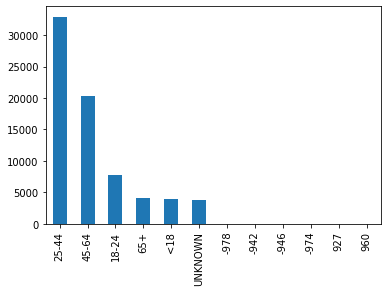

In [17]:
# Graph count plot by victim age

vic_age = violations["VIC_AGE_GROUP"]
print(vic_age)

violations["VIC_AGE_GROUP"].value_counts().plot(kind='bar')

CMPLNT_NUM
781940970    UNKNOWN
835070274    UNKNOWN
868311027    UNKNOWN
249096292      25-44
691512468      18-24
              ...   
708745193      18-24
658271544      25-44
937152058      18-24
705239744    UNKNOWN
981427174      25-44
Name: SUSP_AGE_GROUP, Length: 72670, dtype: object


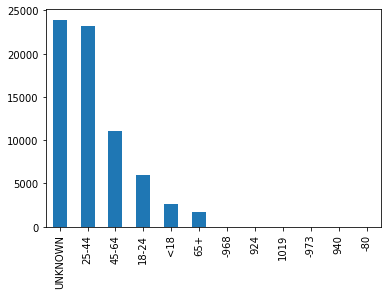

In [18]:
# Graph count plot by suspect age

susp_age = violations["SUSP_AGE_GROUP"]
print(susp_age)

violations["SUSP_AGE_GROUP"].value_counts().plot(kind='bar')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

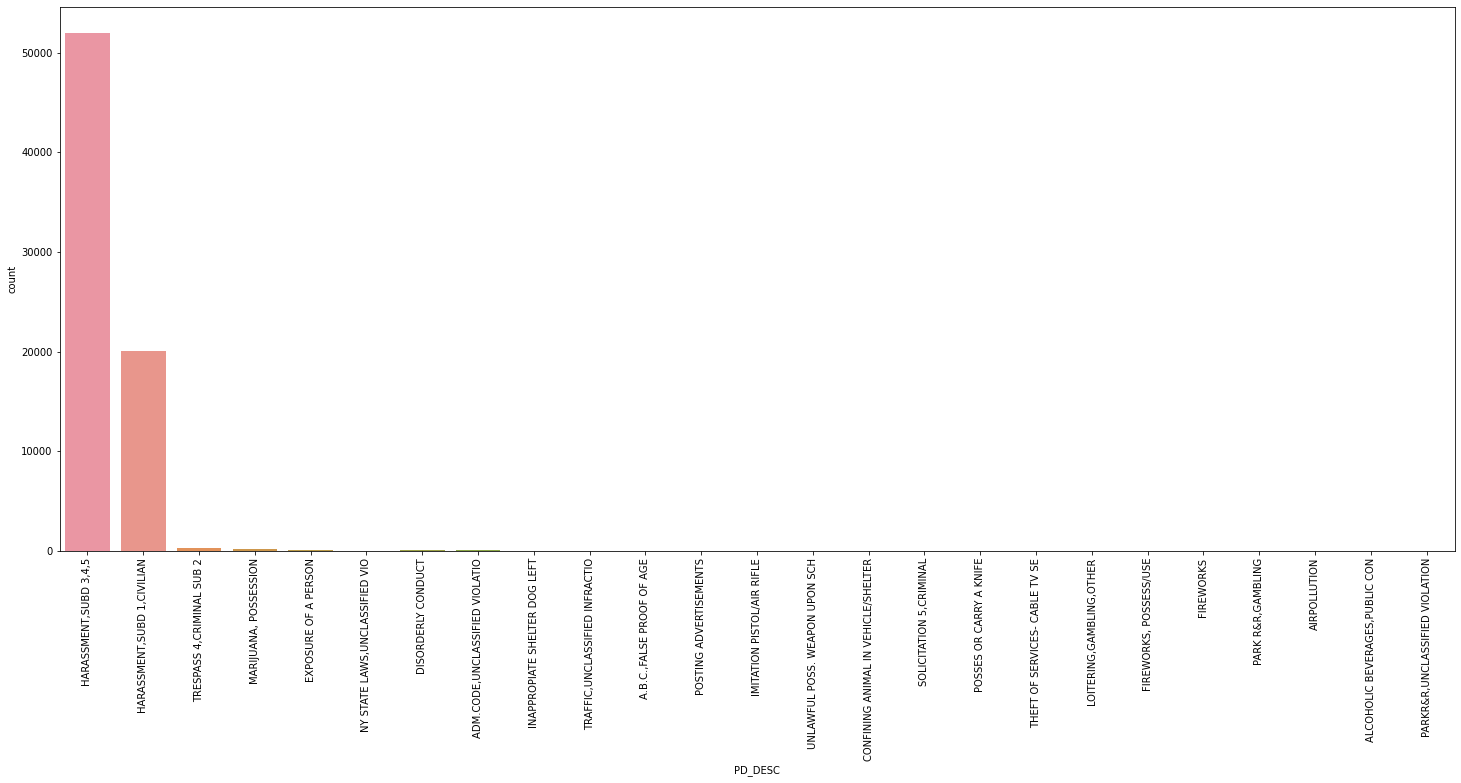

In [19]:
# Plot counts by type of description of internal classification corresponding 
# with PD code (more granular than Offense Description), updated figure size to 
# allow better readability of x axis labels

fig_dims = (25, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(x='PD_DESC', ax = ax, data=violations)
plt.xticks(rotation=90)

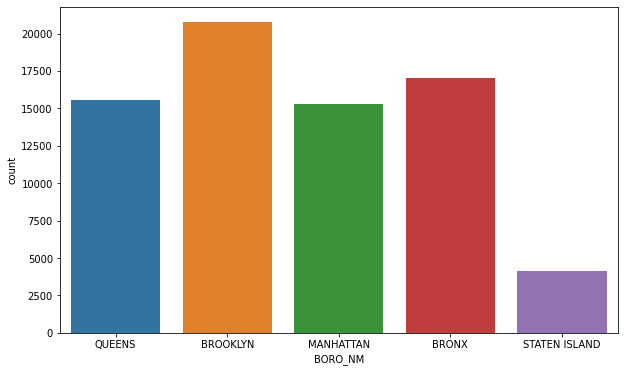

In [20]:
# Plot counts by Borough in which they occurred, updated figure size to allow better readability of x axis labels

fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(x='BORO_NM', ax = ax, data=violations)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73]), <a list of 74 Text major ticklabel objects>)

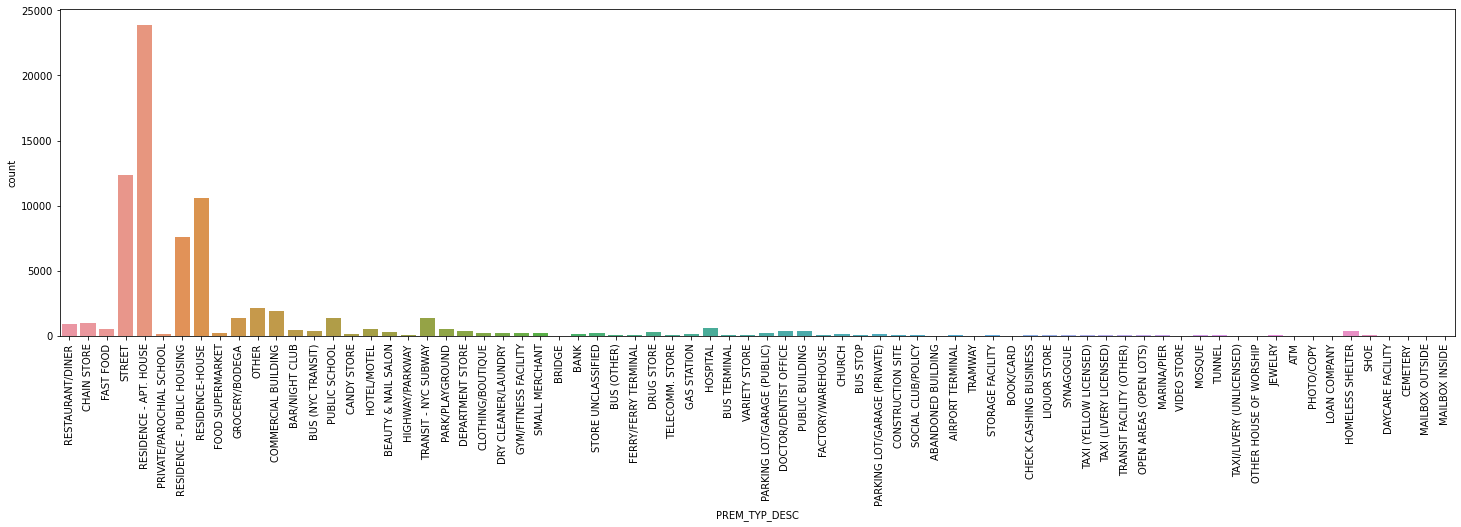

In [21]:
# Plot counts by location in which they occurred, updated figure size to allow better readability of x axis labels

fig_dims = (25, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(x='PREM_TYP_DESC', ax = ax, data=violations)
plt.xticks(rotation=90)

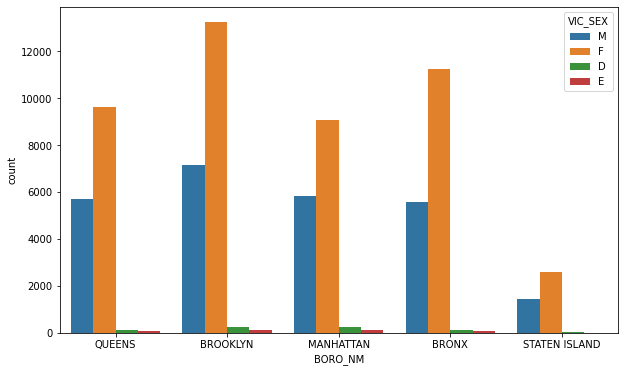

In [22]:
# Are there gender differences in victim sex across borough?

# Females are most often the ones to report complaints, but note that the gender 
# disparity is much greater in Brooklyn and the Bronx.

fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)

sns.countplot(x='BORO_NM', hue = 'VIC_SEX', data=violations)

# For another day: Mapping Complaints

In [23]:
import descartes
!pip install geopandas
from shapely.geometry import Point 
!pip install cartopy
%matplotlib inline

     |████████████████████████████████| 931kB 2.8MB/s 
     |████████████████████████████████| 14.7MB 276kB/s 
     |████████████████████████████████| 10.4MB 35.7MB/s 
     |████████████████████████████████| 8.9MB 2.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 /usr/local/lib/python3.6/dist-packages/pip/_vendor/pep517/_in_process.py get_requires_for_build_wheel /tmp/tmp99w8dlk9 Check the logs for full command output.


In [24]:
# Setting Bounding Box for XY Coords
BBox = (violations.longitude.min(), violations.longitude.max(), violations.latitude.min(), violations.latitude.max())
BBox

AttributeError: ignored

In [0]:
# Sadly the image from BBox was too large to download from open street map.
# Tried another method below that also resulted in difficulty.

# import cartopy.crs as ccrs

# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()

# plt.show()

In [0]:
# Plot complaints

# fig, ax = plt.subplots(figsize = (8,7))
# ax.scatter(violations.longitude, violations.latitude, zorder=1, alpha= 0.2, c='b', s=10)
# ax.set_title('Complaints in NYC')
# ax.set_xlim(BBox[0],BBox[1])
# ax.set_ylim(BBox[2],BBox[3])
# ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')